In [1]:
import pandas as pd
reviews = pd.read_csv("reviews.csv")
reviews.head()

,uid,profile,anime_uid,text,score,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,291149,aManOfCulture99,4181,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=291149


In [2]:
reviews.drop(['uid','profile', 'anime_uid', 'text', 'score', 'link'], axis=1, inplace=True)
reviews.head()

,scores
0,"{'Overall': '8', 'Story': '8', 'Animation': '8..."
1,"{'Overall': '10', 'Story': '10', 'Animation': ..."
2,"{'Overall': '7', 'Story': '7', 'Animation': '9..."
3,"{'Overall': '9', 'Story': '9', 'Animation': '9..."
4,"{'Overall': '10', 'Story': '10', 'Animation': ..."


In [3]:
#splitting the dictionaries.
categories = ['Overall', 'Story', 'Animation', 'Sound', 'Character', 'Enjoyment']
for category in categories:
    reviews[category] = reviews['scores'].apply(lambda x: eval(x)[category])
reviews.head()

,scores,Overall,Story,Animation,Sound,Character,Enjoyment
0,"{'Overall': '8', 'Story': '8', 'Animation': '8...",8,8,8,10,9,8
1,"{'Overall': '10', 'Story': '10', 'Animation': ...",10,10,10,10,10,10
2,"{'Overall': '7', 'Story': '7', 'Animation': '9...",7,7,9,8,8,8
3,"{'Overall': '9', 'Story': '9', 'Animation': '9...",9,9,9,10,10,9
4,"{'Overall': '10', 'Story': '10', 'Animation': ...",10,10,8,9,10,10


In [4]:
#dropping the original scores (dicitonary) column
reviews.drop(['scores'], axis=1, inplace=True)

In [5]:
#assign a label based on the overall score
reviews['label'] = reviews['Overall'].apply(lambda x: 'good' if int(x) >= 8 else 'not good')
reviews.head()

,Overall,Story,Animation,Sound,Character,Enjoyment,label
0,8,8,8,10,9,8,good
1,10,10,10,10,10,10,good
2,7,7,9,8,8,8,not good
3,9,9,9,10,10,9,good
4,10,10,8,9,10,10,good


In [6]:
#split the label into two categroies
#good = 1, not good = 0
reviews['label'] = reviews['label'].apply(lambda x: 1 if x == 'good' else 0)
reviews.head()

,Overall,Story,Animation,Sound,Character,Enjoyment,label
0,8,8,8,10,9,8,1
1,10,10,10,10,10,10,1
2,7,7,9,8,8,8,0
3,9,9,9,10,10,9,1
4,10,10,8,9,10,10,1


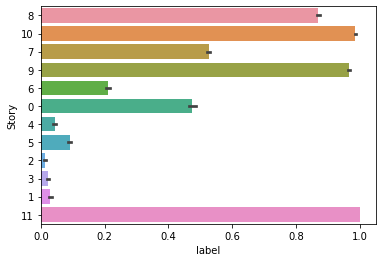

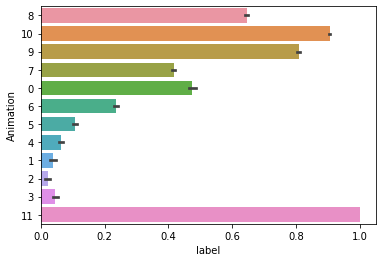

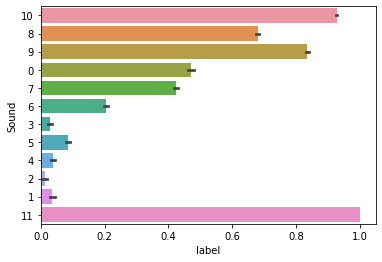

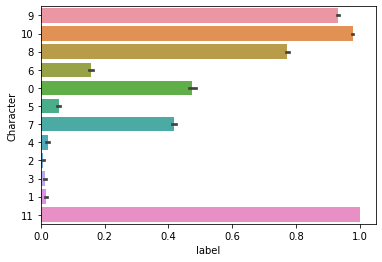

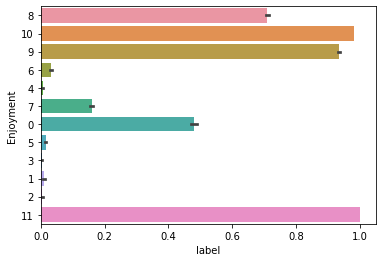

In [7]:
#visualizing the correlation between the features and the label
import matplotlib.pyplot as plt
import seaborn as sns
features = ['Story', 'Animation', 'Sound', 'Character', 'Enjoyment']
for feature in features:
    sns.barplot(x='label', y=feature, data=reviews)
    plt.show()

In [8]:
#splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
X = reviews.drop(['label'], axis=1)
y = reviews['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#validation
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
#Training a random forest classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [10]:
#hyperparameter optimization using hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
space = {
    'n_estimators': hp.choice('n_estimators', [10, 50, 100, 150, 200]),
    'max_depth': hp.choice('max_depth', [10, 20, 30, 40, 50]),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}
print(space)


{'n_estimators': <hyperopt.pyll.base.Apply object at 0x000002C047E2DFD0>, 'max_depth': <hyperopt.pyll.base.Apply object at 0x000002C006DAC5E0>, 'max_features': <hyperopt.pyll.base.Apply object at 0x000002C006DCC0A0>, 'criterion': <hyperopt.pyll.base.Apply object at 0x000002C006DCC220>}


In [11]:
#objective function
#In this step, we define the objective function that hyperopt will minimize.
from sklearn.model_selection import cross_val_score
def objective(space):
    model = RandomForestClassifier(n_estimators=space['n_estimators'],
                                   max_depth=space['max_depth'],
                                   max_features=space['max_features'],
                                   criterion=space['criterion'])
    accuracy = cross_val_score(model, X_train, y_train, cv=5).mean()
    return {'loss': -accuracy, 'status': STATUS_OK}


In [12]:
#finding the best hyperparameters
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=15,
            trials=trials)
print(best)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 15/15 [10:55<00:00, 43.68s/trial, best loss: -1.0]
{'criterion': 0, 'max_depth': 2, 'max_features': 0, 'n_estimators': 4}


In [26]:
#traininf the model with the best hyperparameters
best_model = RandomForestClassifier(n_estimators= best['n_estimators'],
                                    max_depth=  best['max_depth'],
                                    max_features=  1,
                                    )



In [27]:
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, max_features=1, n_estimators=4)

In [28]:
#validating the model
from sklearn.metrics import accuracy_score
y_pred1 = best_model.predict(X_val)
accuracy_score(y_val, y_pred1)

0.9514281996226169

In [29]:
#testing the model
y_pred2 = best_model.predict(X_test)
accuracy_score(y_test, y_pred2)

0.9516474042504738

In [31]:
#saving the model
import pickle
pickle.dump(best_model, open('anime_review_classifier_final.pkl', 'wb'))

In [38]:
best_model.predict([[9, 9, 9, 8, 9,8]])

c:\Users\User\Documents\python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1], dtype=int64)